# Demo Workflow

`model_catalogs` provides easy access to specific curated ocean models through Intake catalogs, with the ultimate product being an `xarray` Dataset.

An Intake catalog has one or more Sources listed in it; a Source is a distinct product that has a `urlpath` pointing to where the model output can be accessed. An Intake catalog can be nested catalogs that each have sources.

In [1]:
import model_catalogs as mc

import intake
import pandas as pd

import os

import xarray as xr

## Main Catalog

The first step is to set up the main catalog. The main catalog provides access to all of the models and the various timings that are available for each model. The catalog is set up by reading in the `transform.yaml` catalog file, pointing it to the hard-wired original ("orig") catalog file for each model, and reading and copying in previously-calculated boundary information for the model (also saved in the repository). Every model catalog in the main catalog has at least a single timing for "forecast", but may have others ("nowcast", "hindcast", "hindcast-forecast-aggregation"). Each of those forecast timing sources in the model catalog has a `urlpath` that points to source for the model output so that a user can look at some model output. If the model output is available at a static link, that link is provided by `urlpath`. If the model output is available as a series of files that need to be aggregated (often for NOAA OFS models), then two example files are provided. The other timings besides "forecast" have either: `urlpath` point to the static access link if available, for nowcast models that have to be aggregated will point to two example files, and the rest (models that need to be aggregated and are timing "hindcast") have `urlpath` of null. Later in the process, the `urlpath` for all aggregated models will be filled in with the full listing of file locations that are requested by the user.

The main catalog is compiled from parts that are saved to the repository, but some of the model catalog files have Intake user parameters for today and/or yesterday that are filled in when the main catalog is run. To save time, the individual compiled catalog files are saved into a user application cache and are considered "fresh" for 6 hours (set in `mc.FRESH['compiled']` in the `__init__` file) since they need to be recreated for each day. When `mc.setup()` is run, the catalog will be put together fresh if either more than 6 hours have passed since last time it was run or `override=True` is input to force it to be recreated. Otherwise, the previously-written catalog files will be reread in.

Each model catalog nested in the main catalog points to an original model catalog as a "target" for an Intake transform in `model_catalogs`. This transform is run when model output is requested from the model with `source.to_dask()` and it applies metadata stored in the model catalogs. The original model information can also be revealed with `source.target`.


<details>
<summary>Sample main catalog</summary>

| `main_cat` <br><br> *Nested Intake Catalog* | `cat` <br><br> *Intake Catalog* | `source` <br><br><br> *Intake Source* | Description |
| :---        |    :----:   |          :--- | :--- |
|     | CIOFS |             |
|     |       |  forecast | static link to pre-aggregated forecast model output   |
|     |       |  nowcast | unaggregated model output from recently through forecast   |
|     |       |  hindcast | unaggregated nowcast model output from the past through not too long ago   |
|     |       |  hindcast-forecast-aggregation | aggregated forecast files from the past   |
|     | WCOFS |             |
|     |       |  forecast | unaggregated model output from recently through forecast  |
|     |       |  hindcast | unaggregated nowcast model output from the past through not too long ago   |
|     | HYCOM |             |
|     |       |  forecast | static link to forecast model output  |
|     | RTOFS-ALASKA |             |
|     |       |  forecast | known links to files, prepopulated with "yesterday" to get correct links  |
|     |       |  nowcast | known links to files, prepopulated with "today" to get correct links. These files are only available midday so aren't as reliable to use as the forecast depending on the time of time.   |

...all the rest are similar
    
</details>



**_NOTE:_** The model domain boundaries are previously calculated and saved into the repository. However, they can be recalculated with `mc.calculate_boundaries()` if a model has been changed.

**_NOTE:_** The user application cache directory can be revealed with `mc.CAT_PATH`.

In [2]:
main_cat = mc.setup()

In [3]:
# Or if you have changed a model catalog file, you can incorporate those changes into main_cat with:
# main_cat = mc.setup(override=True)

See what models are available with:

In [4]:
list(main_cat)

['NYOFS',
 'CIOFS-REGULARGRID',
 'RTOFS-GLOBAL-2D',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'WCOFS-2DS',
 'SFBOFS-REGULARGRID',
 'GFS-1-2DEG',
 'CBOFS-REGULARGRID',
 'LMHOFS-REGULARGRID',
 'LEOFS-REGULARGRID',
 'TBOFS',
 'NGOFS2',
 'WCOFS-REGULARGRID',
 'GOMOFS-REGULARGRID',
 'GFS-1DEG',
 'GOMOFS-2DS',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'NGOFS2-REGULARGRID',
 'LMHOFS',
 'TBOFS-REGULARGRID',
 'DBOFS',
 'LEOFS',
 'SFBOFS',
 'CREOFS-REGULARGRID',
 'NGOFS2-2DS',
 'RTOFS-WEST',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'GFS-1-4DEG',
 'DBOFS-REGULARGRID',
 'CREOFS',
 'LSOFS',
 'CBOFS']

### Examine metadata of models in source catalog

The main catalog contains information about each model. The full list of metadata keys for a model catalog can be found with:

In [5]:
main_cat['CBOFS'].metadata.keys()

dict_keys(['alpha_shape', 'bounding_box', 'filetype', 'geospatial_bounds', 'grid_dim_(xyz)', 'grid_res_max_(km)', 'grid_res_min_(km)', 'grid_type', 'catalog_dir'])

Each source also has its own metadata:

In [6]:
main_cat['CBOFS']['forecast'].metadata.keys()

dict_keys(['axis', 'catalog_dir', 'output_period_(hr)', 'overall_end_datetime', 'overall_start_datetime', 'standard_names'])

#### Domain boundaries

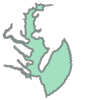

In [7]:
import shapely.wkt

P = shapely.wkt.loads(main_cat['CBOFS'].metadata['geospatial_bounds'])
P

#### Variables

A mapping for the relevant variables to NOAA applications has been written into each source catalog. The mapping is between a standard CF convention variable name to the model dataset variable name. An example list of possible variables used is:

        eastward_sea_water_velocity
        eastward_wind
        northward_sea_water_velocity
        northward_wind
        sea_ice_area_fraction
        sea_ice_thickness
        sea_surface_elevation
        sea_water_temperature
        sea_water_practical_salinity

The full `standard_name` list is available in the [docs](https://model-catalogs.readthedocs.io/en/latest/standard_names.html).

Examine the variable mapping for a given model:

In [8]:
main_cat['CBOFS']['forecast'].metadata['standard_names']

{'eastward_sea_water_velocity': 'u',
 'eastward_wind': 'Uwind',
 'northward_sea_water_velocity': 'v',
 'northward_wind': 'Vwind',
 'ocean_s_coordinate_g1': ['s_rho', 's_w'],
 'sea_floor_depth': 'h',
 'sea_surface_elevation': 'zeta',
 'sea_water_practical_salinity': 'salt',
 'sea_water_temperature': 'temp',
 'time': 'time',
 'upward_sea_water_velocity': 'w'}

### Conveniences: `urlpath`, model output source, and server check

You can find the model output location(s) by querying `urlpath` on a source. Every source has a default `urlpath` that can be checked.

In [9]:
main_cat['CBOFS']['nowcast'].urlpath  # shows 2 default files

['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CBOFS/MODELS/2022/09/25/nos.cbofs.fields.n001.20220925.t00z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CBOFS/MODELS/2022/09/25/nos.cbofs.fields.n002.20220925.t00z.nc']

The datetimes associated with files to be aggregated together from models that have a list of paths in `urlpath` (instead of just a static link) can be examined separately for convenience in the `source`:

In [10]:
main_cat['CBOFS']['nowcast'].dates

[Timestamp('2022-09-24 19:00:00'), Timestamp('2022-09-24 20:00:00')]

The sources in `model_catalogs` are Transforms pointing to other Intake catalog files that are the target of the transforms. The sources are what need to have `urlpath` defined. However, `model_catalogs` brings forward the `urlpath` so you can query it from the transform too. The original model information, the target of the transform, can be found with `source.target`. For example:

In [11]:
main_cat['CBOFS']['nowcast'].target

nowcast:
  args:
    chunks:
      ocean_time: 1
    combine: by_coords
    compat: override
    coords: minimal
    data_vars: minimal
    engine: netcdf4
    parallel: true
    urlpath:
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CBOFS/MODELS/2022/09/25/nos.cbofs.fields.n001.20220925.t00z.nc
    - https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CBOFS/MODELS/2022/09/25/nos.cbofs.fields.n002.20220925.t00z.nc
  description: Unaggregated 3D Chesapeake Bay model in ROMS from 30 days ago with
    48 hour forecast.
  driver: intake_xarray.opendap.OpenDapSource
  metadata:
    axis:
      T: ocean_time
      X:
      - xi_rho
      - xi_u
      - xi_v
      - xi_psi
      Y:
      - eta_rho
      - eta_u
      - eta_v
      - eta_psi
      Z:
      - s_rho
      - s_w
    catalog_dir: /Users/kthyng/projects/model_catalogs/model_catalogs/catalogs/orig/
    catloc: https://opendap.co-ops.nos.noaa.gov/thredds/catalog/NOAA/CBOFS/MODELS/catalog.xml
    output_period_(hr): 

You can also see if the server for a given Source is currently running with

In [12]:
main_cat['CBOFS']['nowcast'].status

True

## Find availability for a model

You can query a specific model for its availability for any or all timings. This is not a necessary step, but is useful for a user choosing the model to use and what is possible. The start and end datetimes found are saved into the user application cache and are reused if still considered fresh (as determined by the FRESH parameters for each timing and start or end times).

* If no timings are input, the availability will be found and inserted into each source in the input model catalog: `mc.find_availability(main_cat['CIOFS'])`
* Alternatively, the user can choose 1 or more timings to check, for example, maybe they are only interested in checking the available datetime range of the forecast timing: `mc.find_availability(main_cat['CIOFS'], timing='forecast')`
* Or, simplest of all, the user can diretly input the Intake Source they want to evaluate: `mc.find_availability(main_cat['CIOFS']['forecast'])`

In the following example, the CIOFS model has had timings all previously checked and some are still fresh for the first run. The second time the request is made, all previously-calculated availabilities are fresh so it is fast to run.

In [13]:
%%time
cat = mc.find_availability(main_cat['CIOFS'])

CPU times: user 479 ms, sys: 18.1 ms, total: 497 ms
Wall time: 2.77 s


In [14]:
%%time
cat = mc.find_availability(main_cat['CIOFS'])

CPU times: user 11.5 ms, sys: 3.34 ms, total: 14.9 ms
Wall time: 13.4 ms


Timing metadata is now available (the forecast aggregation server is currently not working):

In [15]:
print('forecast: ', cat['forecast'].metadata['start_datetime'], ' to ', cat['forecast'].metadata['end_datetime'])
print('nowcast: ', cat['nowcast'].metadata['start_datetime'], ' to ', cat['nowcast'].metadata['end_datetime'])
print('hindcast: ', cat['hindcast'].metadata['start_datetime'], ' to ', cat['hindcast'].metadata['end_datetime'])
print('hindcast-forecast-aggregation: ', cat['hindcast-forecast-aggregation'].metadata['start_datetime'], ' to ', cat['hindcast-forecast-aggregation'].metadata['end_datetime'])

forecast:  2022-09-19T01:00:00.000000000  to  2022-09-28T12:00:00.000000000
nowcast:  2022-08-26 13:00:00  to  2022-09-28 18:00:00
hindcast:  2019-09-16 19:00:00  to  2022-09-22 18:00:00
hindcast-forecast-aggregation:  2019-09-16T19:00:00.000000000  to  2022-09-22T18:00:00.000000000


## Setup model catalog for desired date range

The actual locations of the model files for the unaggregated NOAA OFS models, however, need to be determined and input to the model timing source. `mc.select_date_range()` does this.

There are four modes for `mc.select_date_range()`:

1. Run `mc.find_availability()` for all model timings, then request your desired date range in `mc.select_date_range()` and the code will figure out what timing to use.
1. Skip straight to `mc.select_date_range()` because you know which timing to use for your model, and input that timing.
1. In the special case of there only being one timing in the cat, it does not need to be input.
1. In the special case of the model output being available at a static link or deterministic paths, the function of `mc.select_date_range()` is to input the desired start and end dates into the metadata so that the ultimate Dataset is subselected to that time range.

**_NOTE:_**
Some model sources have static links to the model output, in which case they can be immediately accessed, like the HYCOM forecast. For those models, `mc.select_date_range()` does not need to be run and the model output can be accessed directly from the main catalog. You don't need to know this though — you can use the same process described here too.

**_NOTE:_**
All model sources have some files that work stored in `urlpath` so that you can always run `main_cat[model][timing].to_dask()` and get something back. However, these are sample files and will be replaced with the proper file paths when a user runs `mc.select_date_range()`.

Example of #1. After this is run, model output can be accessed through `source_CIOFS`.

In [16]:
start_date = '2022-08-03'
main_cat = mc.setup()
cat = mc.find_availability(main_cat['CIOFS'])
source_CIOFS = mc.select_date_range(cat, start_date=start_date, end_date=start_date)

In [17]:
source_CIOFS.urlpath  # shows files for the date range selection

['https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n006.20220803.t00z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n001.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n002.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n003.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n004.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n005.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n006.20220803.t06z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n001.20220803.t12z.nc',
 'https://www.ncei.noaa.gov/thredds/dodsC/model-ciofs-files/2022/08/nos.ciofs.fields.n002.20220803.t12z.nc',
 'https://www.ncei.

The dates associated with the newly-found filenames in `urlpath` can be checked with `source.dates`:

In [18]:
source_CIOFS.dates

[Timestamp('2022-08-03 00:00:00'),
 Timestamp('2022-08-03 01:00:00'),
 Timestamp('2022-08-03 02:00:00'),
 Timestamp('2022-08-03 03:00:00'),
 Timestamp('2022-08-03 04:00:00'),
 Timestamp('2022-08-03 05:00:00'),
 Timestamp('2022-08-03 06:00:00'),
 Timestamp('2022-08-03 07:00:00'),
 Timestamp('2022-08-03 08:00:00'),
 Timestamp('2022-08-03 09:00:00'),
 Timestamp('2022-08-03 10:00:00'),
 Timestamp('2022-08-03 11:00:00'),
 Timestamp('2022-08-03 12:00:00'),
 Timestamp('2022-08-03 13:00:00'),
 Timestamp('2022-08-03 14:00:00'),
 Timestamp('2022-08-03 15:00:00'),
 Timestamp('2022-08-03 16:00:00'),
 Timestamp('2022-08-03 17:00:00'),
 Timestamp('2022-08-03 18:00:00'),
 Timestamp('2022-08-03 19:00:00'),
 Timestamp('2022-08-03 20:00:00'),
 Timestamp('2022-08-03 21:00:00'),
 Timestamp('2022-08-03 22:00:00'),
 Timestamp('2022-08-03 23:00:00')]

Example of #2:

In [19]:
today = pd.Timestamp.today()
main_cat = mc.setup()
source_LMHOFS = mc.select_date_range(cat, timing='nowcast', start_date=today, end_date=today)

In [20]:
source_LMHOFS.urlpath  # shows files for the date range selectionsource_CIOFS.urlpath  # shows files for the date range selection

['https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n006.20220926.t00z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n001.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n002.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n003.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n004.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n005.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n006.20220926.t06z.nc',
 'https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CIOFS/MODELS/2022/09/26/nos.ciofs.fields.n001.20220926.t12z.nc',
 'https://opendap.co-ops

Example of #3 and #4:

In [21]:
today = pd.Timestamp.today()
main_cat = mc.setup()
source_HYCOM = mc.select_date_range(main_cat['HYCOM'], start_date=today, end_date=today+pd.Timedelta('1 day'))

In [22]:
source_HYCOM.urlpath

'http://tds.hycom.org/thredds/dodsC/GLBy0.08/latest'

Note that since the HYCOM forecast output is available at a static link, it can also be accessed directly. The difference in the resulting Dataset is that `source_HYCOM_direct` retains all times in the output whereas `source_HYCOM` has been filtered to the specified date range.

In [23]:
source_HYCOM_direct = main_cat['HYCOM']['forecast'].to_dask()

## Read in model output

Model output can be accessed from our examples 1 and 2 above, or from an example with a static link.

Example #1:

In [24]:
%%time
source_CIOFS.to_dask()

CPU times: user 9.26 s, sys: 2.36 s, total: 11.6 s
Wall time: 35.9 s


<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 30, s_w: 31,
                      eta_rho: 1044, xi_rho: 724, eta_u: 1044, xi_u: 723,
                      eta_v: 1043, xi_v: 724, eta_psi: 1043, xi_psi: 723,
                      ocean_time: 24)
Coordinates: (12/19)
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    ...               ...
  * xi_v             (xi_v) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722 723
  * xi_psi           (xi_psi) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 ... 1039 1040 1041 1042 1043
  * eta_u            (eta_u) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042 1043
  * eta_v            (eta_v) int64 0 1 2 3 4 5 ... 1037 1038 1039 1040 1041 1042
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042
Dimensions without coordinates: tracer, boundary
Data variables: (12/77)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    nHIS             int32 ...
    ndefHIS          int32 ...
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
Attributes: (12/34)
    file:                            nos.ciofs.fields.nowcast.20220803.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           ciofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          024x034
    history:                         ROMS/TOMS, Version 3.9, Wednesday - Augu...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               30

Example #2:

In [25]:
%%time
source_LMHOFS.to_dask()

CPU times: user 5.34 s, sys: 1.32 s, total: 6.66 s
Wall time: 16.1 s


<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 30, s_w: 31,
                      eta_rho: 1044, xi_rho: 724, eta_u: 1044, xi_u: 723,
                      eta_v: 1043, xi_v: 724, eta_psi: 1043, xi_psi: 723,
                      ocean_time: 24)
Coordinates: (12/19)
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    ...               ...
  * xi_v             (xi_v) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722 723
  * xi_psi           (xi_psi) int64 0 1 2 3 4 5 6 ... 717 718 719 720 721 722
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 ... 1039 1040 1041 1042 1043
  * eta_u            (eta_u) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042 1043
  * eta_v            (eta_v) int64 0 1 2 3 4 5 ... 1037 1038 1039 1040 1041 1042
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042
Dimensions without coordinates: tracer, boundary
Data variables: (12/78)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    nHIS             int32 ...
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
Attributes: (12/34)
    file:                            nos.ciofs.fields.nowcast.20220926.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           ciofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    tiling:                          024x034
    history:                         ROMS/TOMS, Version 3.9, Monday - Septemb...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               30

Example #3 (if you know you have direct access to static link):

In [26]:
%%time
main_cat['HYCOM']['forecast'].to_dask()

CPU times: user 6.59 ms, sys: 806 µs, total: 7.39 ms
Wall time: 6.8 ms


<xarray.Dataset>
Dimensions:            (depth: 40, lat: 4251, lon: 4500, time: 8)
Coordinates:
  * depth              (depth) float64 0.0 2.0 4.0 6.0 ... 3e+03 4e+03 5e+03
  * lat                (lat) float64 -80.0 -79.96 -79.92 ... 89.92 89.96 90.0
  * lon                (lon) float64 0.0 0.07996 0.16 0.24 ... 359.8 359.8 359.9
  * time               (time) datetime64[ns] 2022-09-26T18:00:00 ... 2022-09-...
    time_run           (time) datetime64[ns] 2022-09-25T12:00:00 ... 2022-09-...
Data variables:
    time_offset        (time) datetime64[ns] ...
    water_u            (time, depth, lat, lon) float32 ...
    water_u_bottom     (time, lat, lon) float32 ...
    water_v            (time, depth, lat, lon) float32 ...
    water_v_bottom     (time, lat, lon) float32 ...
    surf_el            (time, lat, lon) float32 ...
    water_temp         (time, depth, lat, lon) float32 ...
    water_temp_bottom  (time, lat, lon) float32 ...
    salinity           (time, depth, lat, lon) float32 ...
    salinity_bottom    (time, lat, lon) float32 ...
Attributes: (12/14)
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    ...                        ...
    field_type:                instantaneous
    Conventions:               CF-1.4, NAVO_netcdf_v1.1
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:GLBy0.08_930_FMRC

## Other topics

### NOAA OFS models: how to use filetypes besides default 3D "fields"

All NOAA OFS model configurations are available with 3D fields filetypes. However, for some models there are other filetypes:

* `regular_grid`: model output interpolated to rectilinear grid
* `2ds`: only surface model output, variable names changed

You can see what model configurations are available, specifically including filetypes, by looking at the main catalog since they are in the catalog name:

In [27]:
list(main_cat)

['NYOFS',
 'CIOFS-REGULARGRID',
 'RTOFS-GLOBAL-2D',
 'RTOFS-EAST',
 'RTOFS-ALASKA',
 'WCOFS-2DS',
 'SFBOFS-REGULARGRID',
 'GFS-1-2DEG',
 'CBOFS-REGULARGRID',
 'LMHOFS-REGULARGRID',
 'LEOFS-REGULARGRID',
 'TBOFS',
 'NGOFS2',
 'WCOFS-REGULARGRID',
 'GOMOFS-REGULARGRID',
 'GFS-1DEG',
 'GOMOFS-2DS',
 'HYCOM',
 'RTOFS-GLOBAL',
 'CIOFS',
 'NGOFS2-REGULARGRID',
 'LMHOFS',
 'TBOFS-REGULARGRID',
 'DBOFS',
 'LEOFS',
 'SFBOFS',
 'CREOFS-REGULARGRID',
 'NGOFS2-2DS',
 'RTOFS-WEST',
 'LOOFS',
 'WCOFS',
 'GOMOFS',
 'GFS-1-4DEG',
 'DBOFS-REGULARGRID',
 'CREOFS',
 'LSOFS',
 'CBOFS']

In [28]:
start_date = pd.Timestamp.today()
source_TBOFSRG = mc.select_date_range(main_cat['TBOFS-REGULARGRID'], timing='forecast', 
                                      start_date=start_date, end_date=start_date)
ds = source_TBOFSRG.to_dask()

### Access variables and axis

Metadata has been added to the model Datasets to facilitate certain variable and axis accessibility. The variable access is set up by adding standard variable names to the datasets when they are opened, based on the variables available, and the axis accessibility is first by adding some attributes and then by using `cf-xarray`. See the following examples.

Filter an xarray Dataset by the attribute of `standard_name` (returns an xarray Dataset):

In [29]:
ds.filter_by_attrs(standard_name='sea_water_practical_salinity')

<xarray.Dataset>
Dimensions:     (ocean_time: 24, Depth: 11, ny: 393, nx: 329)
Coordinates:
  * Depth       (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 12.0 15.0 20.0 25.0 30.0
    Latitude    (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
    Longitude   (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-09-26 ... 2022-09-26T23:00:00
  * nx          (nx) int64 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328
  * ny          (ny) int64 0 1 2 3 4 5 6 7 8 ... 385 386 387 388 389 390 391 392
Data variables:
    salt        (ocean_time, Depth, ny, nx) float32 dask.array<chunksize=(1, 11, 393, 329), meta=np.ndarray>
Attributes: (12/33)
    file:                            nos.tbofs.fields.nowcast.20220926.t00z_0...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           tbofs nowcast RUN in operational mode
    var_info:                        varinfo.dat
    ...                              ...
    compiler_flags:                  -fp-model precise -ip -O2
    tiling:                          008x016
    history:                         ROMS/TOMS, Version 3.9, Monday - Septemb...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

Alternatively, you could back out the variable name and use it directly (returns an xarray DataArray):

In [30]:
varname = source_TBOFSRG.metadata['standard_names']['sea_water_practical_salinity']
ds[varname]

<xarray.DataArray 'salt' (ocean_time: 24, Depth: 11, ny: 393, nx: 329)>
dask.array<concatenate, shape=(24, 11, 393, 329), dtype=float32, chunksize=(1, 11, 393, 329), chunktype=numpy.ndarray>
Coordinates:
  * Depth       (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 12.0 15.0 20.0 25.0 30.0
    Latitude    (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
    Longitude   (ny, nx) float64 dask.array<chunksize=(393, 329), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-09-26 ... 2022-09-26T23:00:00
  * nx          (nx) int64 0 1 2 3 4 5 6 7 8 ... 321 322 323 324 325 326 327 328
  * ny          (ny) int64 0 1 2 3 4 5 6 7 8 ... 385 386 387 388 389 390 391 392
Attributes:
    long_name:      salinity
    units:          PSU
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity

Refer to time axis without knowing the time variable name with `cf-xarray`:

In [31]:
ds.cf['T']

<xarray.DataArray 'ocean_time' (ocean_time: 24)>
array(['2022-09-26T00:00:00.000000000', '2022-09-26T01:00:00.000000000',
       '2022-09-26T02:00:00.000000000', '2022-09-26T03:00:00.000000000',
       '2022-09-26T04:00:00.000000000', '2022-09-26T05:00:00.000000000',
       '2022-09-26T06:00:00.000000000', '2022-09-26T07:00:00.000000000',
       '2022-09-26T08:00:00.000000000', '2022-09-26T09:00:00.000000000',
       '2022-09-26T10:00:00.000000000', '2022-09-26T11:00:00.000000000',
       '2022-09-26T12:00:00.000000000', '2022-09-26T13:00:00.000000000',
       '2022-09-26T14:00:00.000000000', '2022-09-26T15:00:00.000000000',
       '2022-09-26T16:00:00.000000000', '2022-09-26T17:00:00.000000000',
       '2022-09-26T18:00:00.000000000', '2022-09-26T19:00:00.000000000',
       '2022-09-26T20:00:00.000000000', '2022-09-26T21:00:00.000000000',
       '2022-09-26T22:00:00.000000000', '2022-09-26T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-09-26 ... 2022-09-26T23:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    standard_name:  time
    axis:           T